In [46]:
import os
import glob
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
# import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
pd.set_option('display.max_rows', 500)

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
X_path, y_path = glob.glob('gdrive/My Drive/Gene Expression Prediction/data/train/*')
X_train = pd.read_csv(X_path)
y_train = pd.read_csv(y_path)

In [3]:
X_train.head(3)

,GeneId,H3K4me3,H3K4me1,H3K36me3,H3K9me3,H3K27me3
0,1,2,1,4,1,0
1,1,0,2,1,1,1
2,1,0,0,4,1,1


### H3K4me3
- DNA 패키징 단백질 히스톤 H3에 대한 후성유전적 변형
- 히스톤 H3 단백질(H3)의 4번째 라이신 잔기(K4)에서 트릴메틸화 변형(me3)을 나타냄
	- 라이신: K로 표기, HO2CCH (NH2) (CH2) 4NH2를 갖는 α- 아미노산, 필수 아미노산
	- 트릴메틸화 변형: 3개의 메틸 그룹이 히스톤이 붙는 것, me3
	- 3개의 메틸그룹이 H3K4에 붙어 H3K4me3가 히스톤 테일 프로모터 부분에 많이 있게 됨
- 유전자 발현 조절에 관여하는 마커(전사활성화(transcription activation) 마커)


### H3K4me1
- DNA 패키징 단백질 Histone H3에 대한 후성유전적 변형
- 히스톤 H3 단백질(H3)의 4번째 라이신 잔기(K4)에서 모노메틸화(me1) 변형을 나타냄
- 유전자 인핸서와 관련 있는 표시
	- 인핸서(Enhancer): 프로모터에서 멀리 떨어진 위치에서 유전자의 전사(transcription)를 조절하는 DNA 염기서열
	- [Reference](http://www.ksmcb.or.kr/file/webzine/2015_08_03.pdf)

### H3K36me3
- DNA 패키징 단백질 Histone H3에 대한 후성유전적 변형
- 히스톤 H3 단백질의 36번째 라이신 잔기(K36)에서 트릴메틸화 변형(me3)을 나타냄
- 유전자 본체와 관련 있는 표시


### H3K9me3
- DNA 패키징 단백질 Histone H3에 대한 후성유전적 변형
- 히스톤 H3 단백질의 9번째 라이신 잔기(K9)에서 트릴메틸화(me3)를 나타냄
- 헤테로크로마틴과 관련 있는 표시
	- 헤테로크로마틴(Heterocromatin): DNA가 히스톤을 빠듯하게 감고 있는 뉴클레오좀 상태
	- 유크로마틴(Euchromatin): DNA가 히스톤을 느슨하게 감고 있는 뉴클레오좀 상태
	- 히스톤 꼬리(tail)에 달라 붙는 효소와 단백질에 따라 뉴클레오좀 상태가 결정됨. 즉, 달라붙은 단백질를 표식(Marker)으로 삼아 뉴클레오좀 상태를 가늠할 수 있음

### H3K27me3
- DNA 패키징 단백질 Histone H3에 대한 후성유전적 변형
- 히스톤 H3 단백질의 27 번째 라이신 잔기에서 트리메틸 화를 나타내는 마크
- 트리메틸화는 헤테로크로마틱 영역 구성을 통해 근처 유전자의 하향조절(downregulation)과 관련

In [4]:
train_raw = X_train.merge(y_train, how='left', on='GeneId')
train_raw.head(3)

,GeneId,H3K4me3,H3K4me1,H3K36me3,H3K9me3,H3K27me3,Prediction
0,1,2,1,4,1,0,0
1,1,0,2,1,1,1,0
2,1,0,0,4,1,1,0


In [5]:
yesExpression = train_raw[train_raw['Prediction']==1].reset_index(drop=True)
noExpression = train_raw[train_raw['Prediction']==0].reset_index(drop=True)

Text(0.5, 1.0, 'H3 Modification Region Index (Median)')

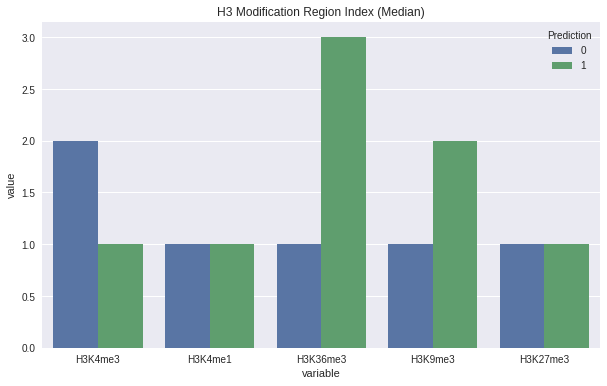

In [43]:
temp = train_raw.groupby(['Prediction']).median().drop('GeneId', axis=1)
temp = temp.reset_index()
temp = pd.melt(temp, id_vars='Prediction')

plt.figure(figsize=(10, 6))
sns.barplot(x='variable', y='value', hue='Prediction', data=temp)
plt.title('H3 Modification Region Index (Median)')

Text(0.5, 1.0, 'H3 Modification Region Index (Mean)')

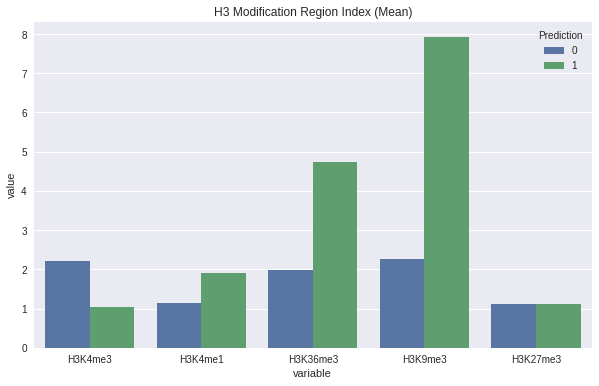

In [44]:
temp = train_raw.groupby(['Prediction']).mean().drop('GeneId', axis=1)
temp = temp.reset_index()
temp = pd.melt(temp, id_vars='Prediction')

plt.figure(figsize=(10, 6))
sns.barplot(x='variable', y='value', hue='Prediction', data=temp)
plt.title('H3 Modification Region Index (Mean)')

Text(0.5, 1.0, 'H3 Modification Region Index (std)')

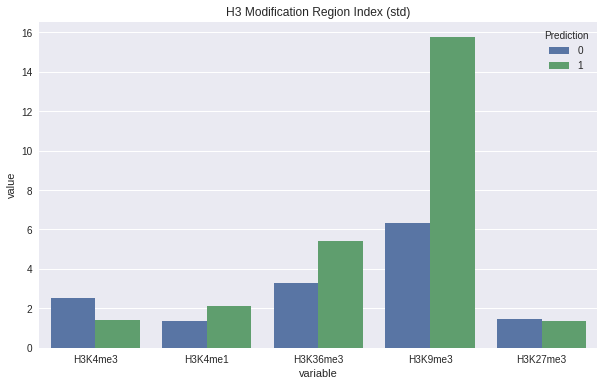

In [46]:
temp = train_raw.groupby(['Prediction']).std().drop('GeneId', axis=1)
temp = temp.reset_index()
temp = pd.melt(temp, id_vars='Prediction')

plt.figure(figsize=(10, 6))
sns.barplot(x='variable', y='value', hue='Prediction', data=temp)
plt.title('H3 Modification Region Index (std)')

In [47]:
feature_list = ['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']

def plotDist(feature=feature_list[0], figsize=(10,6), estimator='mean'):
    if estimator=='mean':
        plt.figure(figsize=(10,6))
        temp = train_raw[['GeneId', f'{feature}', 'Prediction']].groupby('GeneId').mean()
        temp_yesExp = temp[temp['Prediction']==1]
        temp_noExp = temp[temp['Prediction']==0]
        sns.distplot(temp_yesExp[f'{feature}'], norm_hist=True, label='Yes Expression')
        sns.distplot(temp_noExp[f'{feature}'], norm_hist=True, label='No Expression')
        plt.legend()
        plt.show()
    elif estimator=='median':
        plt.figure(figsize=(10,6))
        temp = train_raw[['GeneId', f'{feature}', 'Prediction']].groupby('GeneId').median()
        temp_yesExp = temp[temp['Prediction']==1]
        temp_noExp = temp[temp['Prediction']==0]
        sns.distplot(temp_yesExp[f'{feature}'], norm_hist=True, label='Yes Expression', kde=False)
        sns.distplot(temp_noExp[f'{feature}'], norm_hist=True, label='No Expression', kde=False)
        plt.legend()
        plt.show()

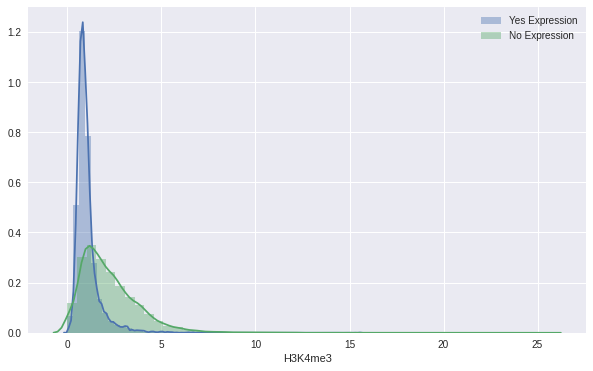

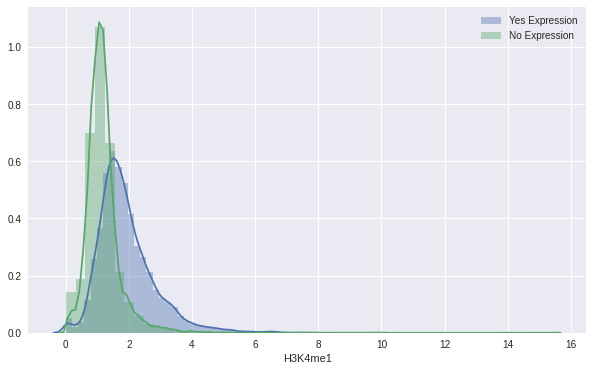

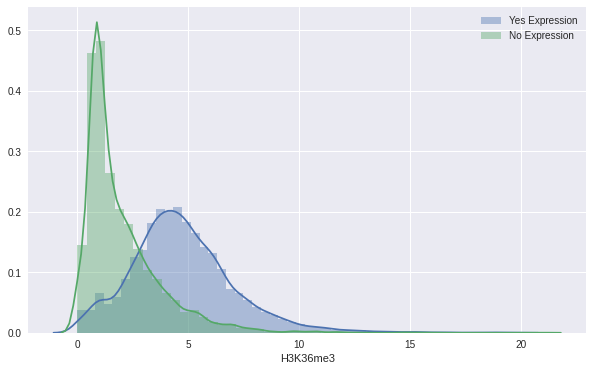

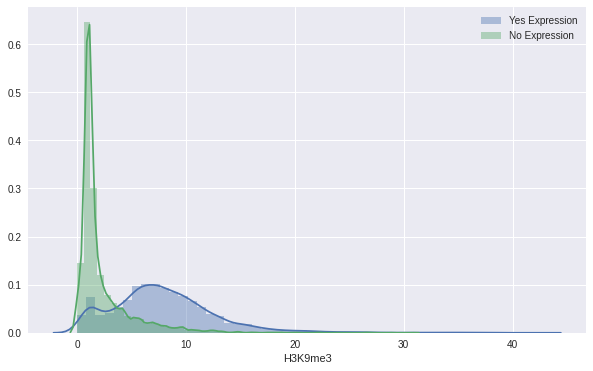

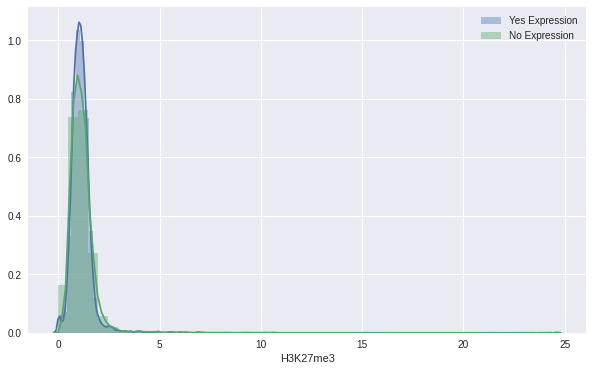

In [48]:
for f in feature_list:
    plotDist(feature=f, figsize=(5,3))

H3K9me3, H3K36me3, H3K4me1: 유전자 발현 여부에 따라 확연한 분포 차이를 보임

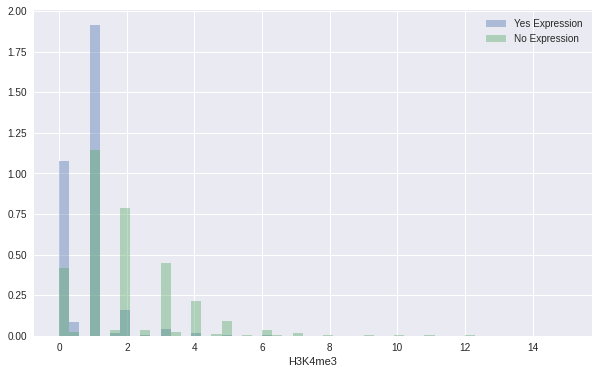

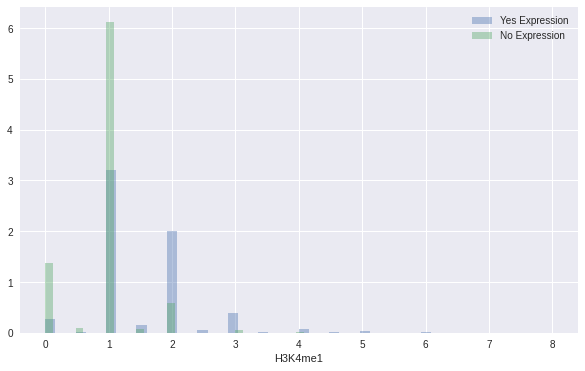

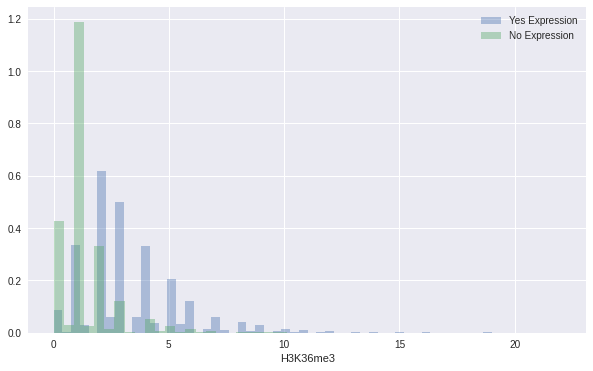

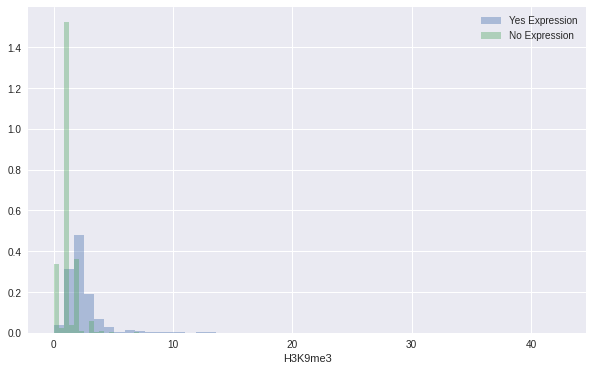

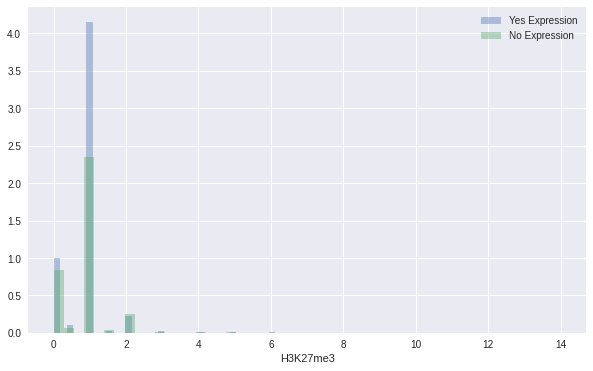

In [49]:
for f in feature_list:
    plotDist(feature=f, estimator='median', figsize=(5,3))

In [6]:
train_TCN = pd.DataFrame(
    np.vstack(
        (
            train_raw
         .groupby('GeneId')
         .apply(lambda x: x.drop(['GeneId', 'Prediction'], axis=1)
        .values.reshape(500, 1)))
        .apply(lambda x: x.flatten())
        .values
        )
)
train_TCN['GeneId'] = train_raw['GeneId'].unique().tolist()
train_TCN = (
    train_TCN.merge(
        train_raw
        .groupby('GeneId')['Prediction']
        .first().to_frame('Prediction')
        .reset_index(), 
        how='left', 
        on='GeneId'
        )
    )

train_TCN.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,GeneId,Prediction
0,2,1,4,1,0,0,2,1,1,1,0,0,4,1,1,0,2,2,0,1,2,0,0,0,0,1,2,0,0,1,2,2,2,0,1,1,1,4,2,2,...,0,0,0,4,1,1,0,1,1,0,0,0,1,1,0,0,1,1,3,0,0,1,1,1,0,1,0,0,2,2,1,0,0,4,1,0,0,1,1,0
1,1,0,1,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,1,0,0,1,0,1,2,0,1,0,0,0,3,0,1,0,1,3,0,0,0,1,...,0,0,1,1,1,2,0,1,2,2,0,2,0,2,0,0,1,0,2,0,0,0,1,1,0,0,0,3,5,1,1,1,2,2,1,0,0,0,2,0
2,1,6,3,1,1,1,6,1,2,2,0,3,3,2,1,0,8,7,1,0,0,11,5,0,3,0,10,5,2,2,1,7,2,0,1,2,7,1,3,2,...,2,2,1,2,2,1,4,1,2,2,4,0,1,1,2,1,0,0,1,0,3,1,3,1,2,0,1,3,1,1,4,2,0,3,4,4,3,0,3,1


In [7]:
path = 'gdrive/My Drive/Gene Expression Prediction/data/'
train_TCN.to_csv(os.path.join(path, 'train_TCN.csv'), index=False)

In [8]:
# 데이터 구성
train, valid = train_test_split(
    train_TCN.drop('GeneId', axis=1), 
    test_size=.3, 
    shuffle=True, 
    random_state=42)
train.shape, valid.shape

((10839, 501), (4646, 501))

### XGBoost

In [9]:
model = (
    xgb.XGBClassifier(random_state=42)
    .fit(train.drop('Prediction', axis=1).values, train['Prediction'])
         )

# AUROC
roc_auc_score(valid['Prediction'], 
              model.predict_proba(valid.drop('Prediction', axis=1).values)[:, 1])

0.9142893650678341

In [25]:
kf = KFold(n_splits=4, random_state=42, shuffle=True)
auc_list = []
for train_index, test_index in kf.split(train):
    X_train, X_test = train.iloc[train_index.tolist(), :].drop('Prediction', axis=1), train.iloc[test_index.tolist(), :].drop('Prediction', axis=1)
    y_train, y_test = train['Prediction'].iloc[train_index.tolist()], train['Prediction'].iloc[test_index.tolist()]

    model = (
        xgb.XGBClassifier(random_state=42)
        .fit(X_train.values, y_train)
        )
    # AUROC
    auc_list.append(roc_auc_score(y_test, 
              model.predict_proba(X_test.values)[:, 1]))

In [28]:
print(auc_list)
print(np.mean(auc_list))

[0.9175725658911309, 0.9181631513732111, 0.9038939578131876, 0.9185571564125777]
0.9145467078725269


### LightGBM

Boosting Type: GOSS

In [31]:
model = (
    lgb.LGBMClassifier(random_state=42, boosting_type='goss')
    .fit(train.drop('Prediction', axis=1).values, train['Prediction'])
         )

# AUROC
roc_auc_score(valid['Prediction'], 
              model.predict_proba(valid.drop('Prediction', axis=1).values)[:, 1])

0.9100378717682238

In [38]:
kf = KFold(n_splits=4, random_state=42, shuffle=True)
auc_list = []
for train_index, test_index in kf.split(train):
    X_train, X_test = train.iloc[train_index.tolist(), :].drop('Prediction', axis=1), train.iloc[test_index.tolist(), :].drop('Prediction', axis=1)
    y_train, y_test = train['Prediction'].iloc[train_index.tolist()], train['Prediction'].iloc[test_index.tolist()]

    model = (
        lgb.LGBMClassifier(random_state=42, boosting_type='goss')
        .fit(X_train.values, y_train)
        )
    # AUROC
    auc_list.append(roc_auc_score(y_test, 
              model.predict_proba(X_test.values)[:, 1]))

In [39]:
print(auc_list)
print(np.mean(auc_list))

[0.9157880002461845, 0.9114720660121731, 0.899307416460787, 0.9169980477057815]
0.9108913826062316


Boosting Type: GBDT

In [34]:
model = (
    lgb.LGBMClassifier(random_state=42, boosting_type='gbdt')
    .fit(train.drop('Prediction', axis=1).values, train['Prediction'])
         )

# AUROC
roc_auc_score(valid['Prediction'], 
              model.predict_proba(valid.drop('Prediction', axis=1).values)[:, 1])

0.9141309174174554

In [35]:
kf = KFold(n_splits=4, random_state=42, shuffle=True)
auc_list = []
for train_index, test_index in kf.split(train):
    X_train, X_test = train.iloc[train_index.tolist(), :].drop('Prediction', axis=1), train.iloc[test_index.tolist(), :].drop('Prediction', axis=1)
    y_train, y_test = train['Prediction'].iloc[train_index.tolist()], train['Prediction'].iloc[test_index.tolist()]

    model = (
        lgb.LGBMClassifier(random_state=42, boosting_type='gbdt')
        .fit(X_train.values, y_train)
        )
    # AUROC
    auc_list.append(roc_auc_score(y_test, 
              model.predict_proba(X_test.values)[:, 1]))

In [37]:
print(auc_list)
np.mean(auc_list)

[0.9180401531355034, 0.9205392083441128, 0.9003406273556337, 0.917380326545748]


0.9140750788452494

### SVM

In [32]:
model = (
    SVC(random_state=42, probability=True)
    .fit(train.drop('Prediction', axis=1).values, train['Prediction'])
         )

# AUROC
roc_auc_score(valid['Prediction'], 
              model.predict_proba(valid.drop('Prediction', axis=1).values)[:, 1])

0.908428747852154

### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = (
    RandomForestClassifier(random_state=42)
    .fit(train.drop('Prediction', axis=1).values, train['Prediction'])
         )

# AUROC
roc_auc_score(valid['Prediction'], 
              model.predict_proba(valid.drop('Prediction', axis=1).values)[:, 1])

0.9083082905740882

In [41]:
kf = KFold(n_splits=4, random_state=42, shuffle=True)
auc_list = []
for train_index, test_index in kf.split(train):
    X_train, X_test = train.iloc[train_index.tolist(), :].drop('Prediction', axis=1), train.iloc[test_index.tolist(), :].drop('Prediction', axis=1)
    y_train, y_test = train['Prediction'].iloc[train_index.tolist()], train['Prediction'].iloc[test_index.tolist()]

    model = (
        RandomForestClassifier(random_state=42)
        .fit(X_train.values, y_train)
        )
    # AUROC
    auc_list.append(roc_auc_score(y_test, 
              model.predict_proba(X_test.values)[:, 1]))

In [42]:
print(auc_list)
np.mean(auc_list)

[0.9173073183803453, 0.9185841696055337, 0.9000230933800429, 0.9181754229061917]


0.9135225010680283